In [1]:
# project: p6
# submitter: kyou24
# partner: none
# hours: 24

In [2]:
#IMPORTS
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import numpy
import sklearn
import sklearn.linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import rasterio
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.impute
import sklearn.compose
from sklearn.metrics import r2_score

In [3]:
#Q1
countiesGDF = gpd.read_file('counties.geojson')
wiscCounties = len(countiesGDF)
wiscCounties

72

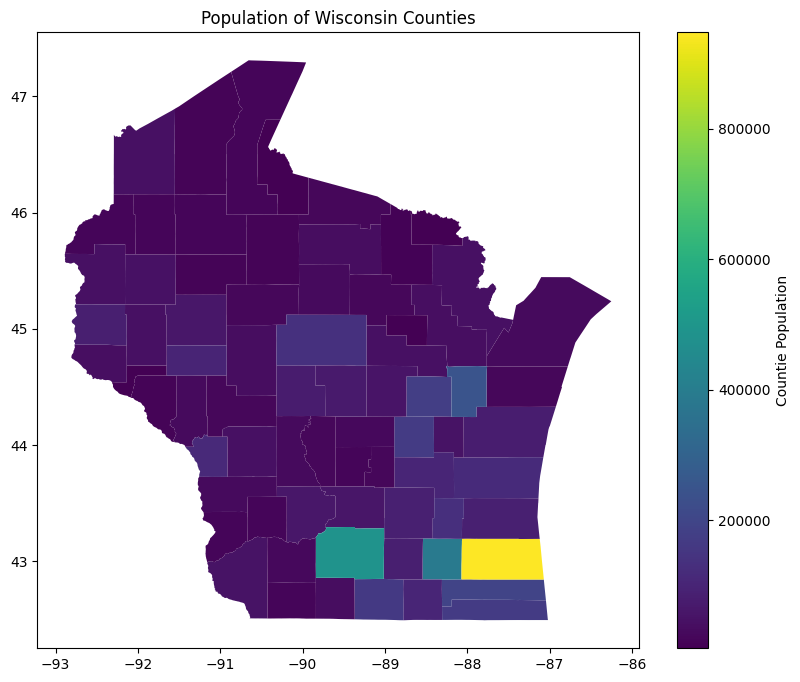

In [4]:
#Q2
fig, ax = plt.subplots(figsize=(10, 8))
countiesGDF.plot(column='POP100', ax=ax, legend=True, legend_kwds={'label': "Countie Population", 'orientation': "vertical"})
plt.title('Population of Wisconsin Counties')
#plt.show()
conn = sqlite3.connect('counties_tracts.db')

#temp = pd.read_sql("SELECT * FROM sqlite_master", conn)
#print(temp.head)

tableData = pd.read_sql("SELECT * FROM counties", conn)
#print(tableData.head())

countiesGDF['AREALAND'] = tableData['AREALAND']
#print(countiesGDF.head)
conn.close()

x = countiesGDF.drop(columns = ['POP100'])
y = countiesGDF['POP100']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=250)

In [5]:
#Q3
x_test['NAME'].tolist()

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [6]:
#Q4
countiesModel = sklearn.linear_model.LinearRegression()

x = numpy.array(x_train['AREALAND']).reshape(-1,1)
y = numpy.array(y_train).reshape(-1,1)

countiesModel.fit(x, y)
pred = countiesModel.predict(numpy.array(x_test['AREALAND']).reshape(-1,1))

r2_score(y_test, pred)


0.016720430179409274

In [7]:
#Q5 
num = 400*2590000
float(countiesModel.predict(numpy.array(num).reshape(-1,1)))

/tmp/ipykernel_38200/189514647.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(countiesModel.predict(numpy.array(num).reshape(-1,1)))


90000.07422783462

In [8]:
#Q6
conn = sqlite3.connect('counties_tracts.db')


temp = pd.read_sql("SELECT * FROM sqlite_master", conn)
tableDataC = pd.read_sql("SELECT * FROM counties", conn)
tableDataT = pd.read_sql("SELECT * FROM tracts", conn)

conn.close()
tableData = pd.merge(tableDataC, tableDataT, on = 'COUNTY')
tableData = tableData.rename(columns={'NAME_x': 'NAME'})
col = tableData.groupby('NAME')['HU100'].sum().reset_index()
tableDataWithCol = pd.merge(tableData, col, on='NAME')
nameTable = tableDataWithCol['NAME'].drop_duplicates()
HU100Table = pd.merge(nameTable, col, on='NAME')
newCountiesGDF = pd.merge(countiesGDF, HU100Table, on='NAME')


x2 = newCountiesGDF.drop(columns = ['POP100'])
y2 = newCountiesGDF['POP100']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.25, random_state=250)
x_test2['NAME'].tolist()

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [9]:
#Q7
dict(zip(x_test2['NAME'], x_test2['HU100']))

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [10]:
#Q8

newCountiesModel = sklearn.linear_model.LinearRegression()

x2 = numpy.array(x_train2['HU100']).reshape(-1,1)
y2 = numpy.array(y_train2).reshape(-1,1)

newCountiesModel.fit(x2, y2)
cross_val_score(newCountiesModel, x2, y2, cv=5).sum() / 5

0.9739348181232653

In [11]:
#Q9
scores = cross_val_score(newCountiesModel, x2, y2, cv=5)
scoresMean = numpy.mean(scores)
scoresVariance = numpy.mean(numpy.power((scores - scoresMean), 2))

numpy.power(scoresVariance, 0.5)

0.01693954236334351

In [12]:
#Q10

coef = newCountiesModel.coef_[0]
intercept = newCountiesModel.intercept_

coef = numpy.round(coef, 2)
intercept = numpy.round(intercept, 2)

res = f'POP100 = {coef[0]}*HU100 + {intercept[0]}'
res

'POP100 = 2.47*HU100 + -9276.89'

Text(0.5, 1.0, 'POP100 vs HU100')

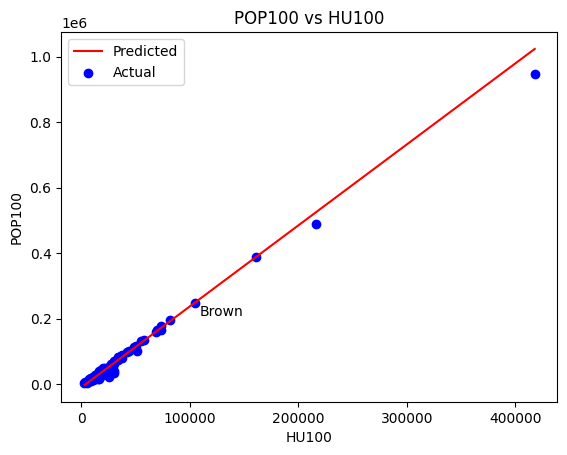

In [13]:
#Q11
fig, ax = plt.subplots()
xAxis = x_train2['HU100'].tolist() + x_test2['HU100'].tolist()
yAxis = y_train2.tolist() + y_test2.tolist()


HU100 = numpy.linspace(3000, max(xAxis), 100)  
POP100 = 2.47 * HU100 - 9276.89 



brownCountyRow = newCountiesGDF.loc[newCountiesGDF['NAME'] == 'Brown County']
brownCountyX = int(brownCountyRow['HU100'])
brownCountyY = int(brownCountyRow['POP100'])


ax.plot(HU100, POP100, color='red', markersize=5, label='Predicted')
ax.scatter(xAxis, yAxis, c='b', label='Actual')
ax.text(brownCountyX + 5000, brownCountyY-40000, 'Brown', fontsize=10)


ax.legend()
ax.set_xlabel('HU100')
ax.set_ylabel('POP100')
ax.set_title('POP100 vs HU100')

In [14]:
#Q12
a = numpy.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

((a >= 3) & (a <= 6)).astype(int).sum()

8

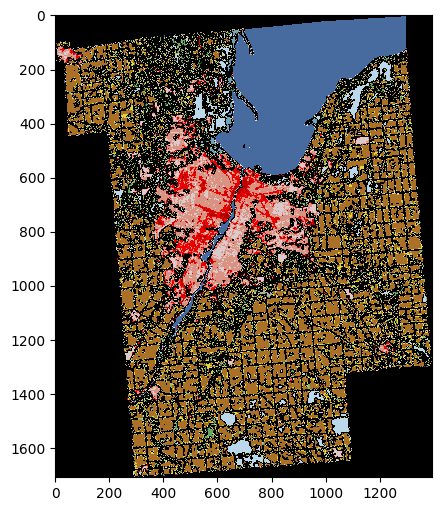

In [15]:
#Q13
with rasterio.open("zip://../p6/land.zip!wi.tif") as land:
    brownCounty = newCountiesGDF[newCountiesGDF['NAME'] == 'Brown County']
    matrix, _ = mask(land, brownCounty.to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    
    
c = numpy.zeros((256, 3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)


fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(matrix, cmap=custom_cmap, vmin=0, vmax=255)
plt.show()


#fig, ax = plt.subplots(figsize=(6,6))
#ax.imshow(matrix, vmin=0, vmax=255)

In [16]:
#Q14
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}


open_water_code = land_use['open_water'] 

totalBrownCells = numpy.count_nonzero(matrix)  
openWaterCells = numpy.count_nonzero(matrix == open_water_code)  

if totalBrownCells == 0:
    res = 0    
else:
    res = openWaterCells / totalBrownCells 
res

0.13797526789725206

Text(0, 0.5, 'POP')

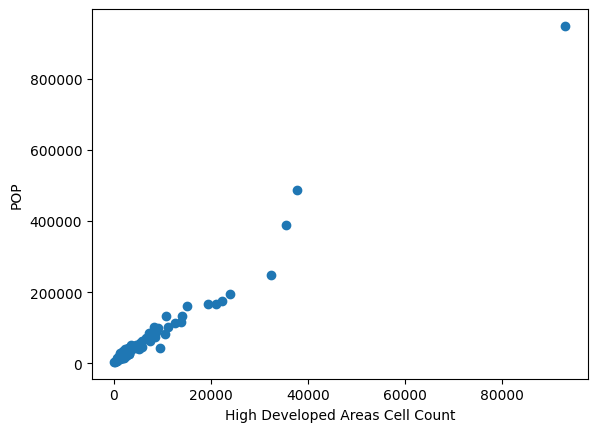

In [17]:
#Q15
counties = newCountiesGDF['NAME']

xAxis = []
yAxis = []

with rasterio.open("zip://../p6/land.zip!wi.tif") as land:
    for c in list(counties):
        county = newCountiesGDF[newCountiesGDF['NAME'] == c]
        matrix, _ = mask(land, county.to_crs(land.crs)["geometry"], crop=True)
        
        code = land_use['developed_high'] 
        cells = numpy.count_nonzero(matrix == code) 
        
        xAxis.append(cells)
        yAxis.append(int(county['POP100']))
        
fig,ax = plt.subplots()
ax.scatter(xAxis, yAxis)
ax.set_xlabel('High Developed Areas Cell Count')
ax.set_ylabel('POP')  

"\nAccording to the accuracy model, developed_med is the most important column when accurately predicting POP100 for each polygon. \nWe know this because when we check the score for each dropped feature, the accuracy dropped to it's lowest when developed_med\nis removed from the features dataset. Therefore, developed_med is the most relied on column when predicting POP100 for each polygon.\n"

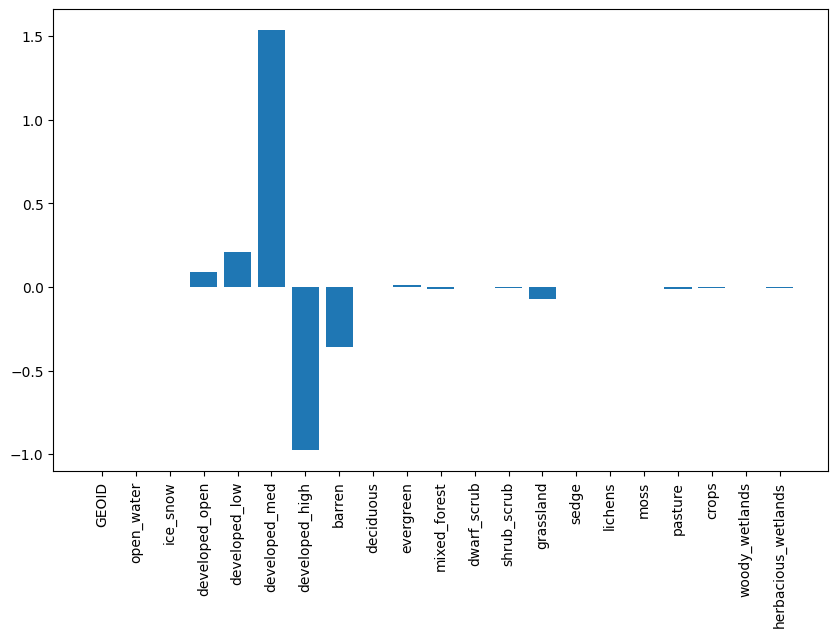

In [18]:
#Q16
tractsGPD = gpd.read_file('tracts.shp')


with rasterio.open("zip://../p6/land.zip!wi.tif") as land:
    
    landData = land.read(1)
    tractsGPD = tractsGPD.to_crs(land.crs)

    for idx, row in tractsGPD.iterrows():
        matrix, _ = mask(land, [row['geometry']], crop=True)
        for landCode, landType in land_use.items():
            code = land_use[landCode]
            tractsGPD.at[idx, landCode] = numpy.count_nonzero(matrix == code)
            
    tractsModel = sklearn.linear_model.LinearRegression()
    x3 = tractsGPD.drop(columns = ['POP100', 'geometry'])
    y3 = tractsGPD['POP100']
    x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=0.2, random_state=300)

    features = tractsGPD.columns.tolist()
    features.remove('geometry')
    features.remove('POP100')
    tractsModel.fit(x_train3, y_train3)
    
    
    plt.figure(figsize=(10, 6))
    plt.bar(features, tractsModel.coef_)
    plt.xticks(rotation=90)
    
    '''
    scores = []
    x = tractsGPD.drop(columns = ['geometry', 'POP100'])
    for col in x:
        feature = x.drop(col, axis = 1)
        tractsModel.fit(feature, y3)
        scores.append(tractsModel.score(feature, y3))
    plt.bar(features, scores)
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Model Accuracy')
    plt.title('Model Accuracy vs Features')
    '''
    
'''
According to the accuracy model, developed_med is the most important column when accurately predicting POP100 for each polygon. 
We know this because when we check the score for each dropped feature, the accuracy dropped to it's lowest when developed_med
is removed from the features dataset. Therefore, developed_med is the most relied on column when predicting POP100 for each polygon.
'''

In [19]:
#MODEL A - Only tracks developed areas
tractsModelA = sklearn.linear_model.LinearRegression()
xA = tractsGPD.drop(columns = tractsGPD.drop(columns = ['developed_open', 'developed_low', 'developed_med', 'developed_high']).columns.tolist())
yA = tractsGPD['POP100']
x_trainA, x_testA, y_trainA, y_testA = train_test_split(xA, yA, test_size=0.2, random_state=300)
tractsModelA.fit(x_trainA, y_trainA)



scoresA = cross_val_score(tractsModelA, xA, yA, cv=5)
scoresMeanA = numpy.mean(scoresA) #scoresMeanA = 0.4176478292117555
#print(scoresMeanA)
varianceA = numpy.mean(numpy.power((scoresA - scoresMeanA), 2)) #varianceA = 0.0019248248562998328
#print(varianceA)


y_pred_testA = tractsModelA.predict(x_testA)
explained_varianceA = r2_score(y_testA, y_pred_testA) #explained_varianceA = 0.40095589320698155
#print(explained_varianceA)



#MODEL B - Doesn't track developed areas ----------------------------------------------------------------------------------------
tractsModelB = sklearn.linear_model.LinearRegression()
xB = tractsGPD.drop(columns = ['developed_open', 'developed_low', 'developed_med', 'geometry', 'POP100'])
yB = tractsGPD['POP100']
x_trainB, x_testB, y_trainB, y_testB = train_test_split(xB, yB, test_size=0.2, random_state=300)
tractsModelB.fit(x_trainB, y_trainB)



scoresB = cross_val_score(tractsModelB, xB, yB, cv=5)
scoresMeanB = numpy.mean(scoresB) #scoresMeanB = 0.13912611824011206
#print(scoresMeanB)
varianceB = numpy.mean(numpy.power((scoresB - scoresMeanB), 2)) #varianceB = 0.0028259099571236205
#print(varianceB)



y_pred_testB = tractsModelB.predict(x_testB)
explained_varianceB = r2_score(y_testB, y_pred_testB) # explained_varianceB = 0.17009467980816084
#print(explained_varianceB)


In [20]:
#Q17

'''
The mean and variance of model A are 0.4176 and 0.0019 respectively, while model B's mean and variance were 0.1392 and 
0.0028 respectively. Model A has the greater cross validation mean and the cross validation variance is also lower. On
the other hand, model B has a lower mean and a greater variance, indicating model B performs worse across multiple cross
validation tests and greater variance indicates more variable answers, reducing the consistency of model B. Model A also 
has more intuitively accurate data, as most of the population would be in a developed area rather than a land type like
a wetland or barren land like what model B relies on. So I would recommend model A over model B.
'''

explained_varianceA

0.40095589320698155